##### <font color=#A0A0A0>
##### ════════════════════════════════════════════════════════
#####     🦾🤖 **MODEL TRAINING WITH THE OXFORD DATASET DATASET**
##### ════════════════════════════════════════════════════════ </font>

#### 🎯 Project Objetive
Make a general neural network with some of the most important configurations. Test it with different data sets and track it's performance with differents hyperparameters

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

3.2.0
Using default data dir C:\Users\PERSONAL\tensorflow_datasets\oxford_iiit_pet\4.0.0 instead.
e:\Users\PERSONAL\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 2/2 [00:00<00:00, 37.74 url/s]
Extraction completed...: 0 file [00:00, ? file/s]
Dl Completed...: 100%|██████████| 2/2 [00:00<00:00, 32.79 url/s]


Dataset oxford_iiit_pet downloaded and prepared to C:\Users\PERSONAL\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [2]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\PERSONAL\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        

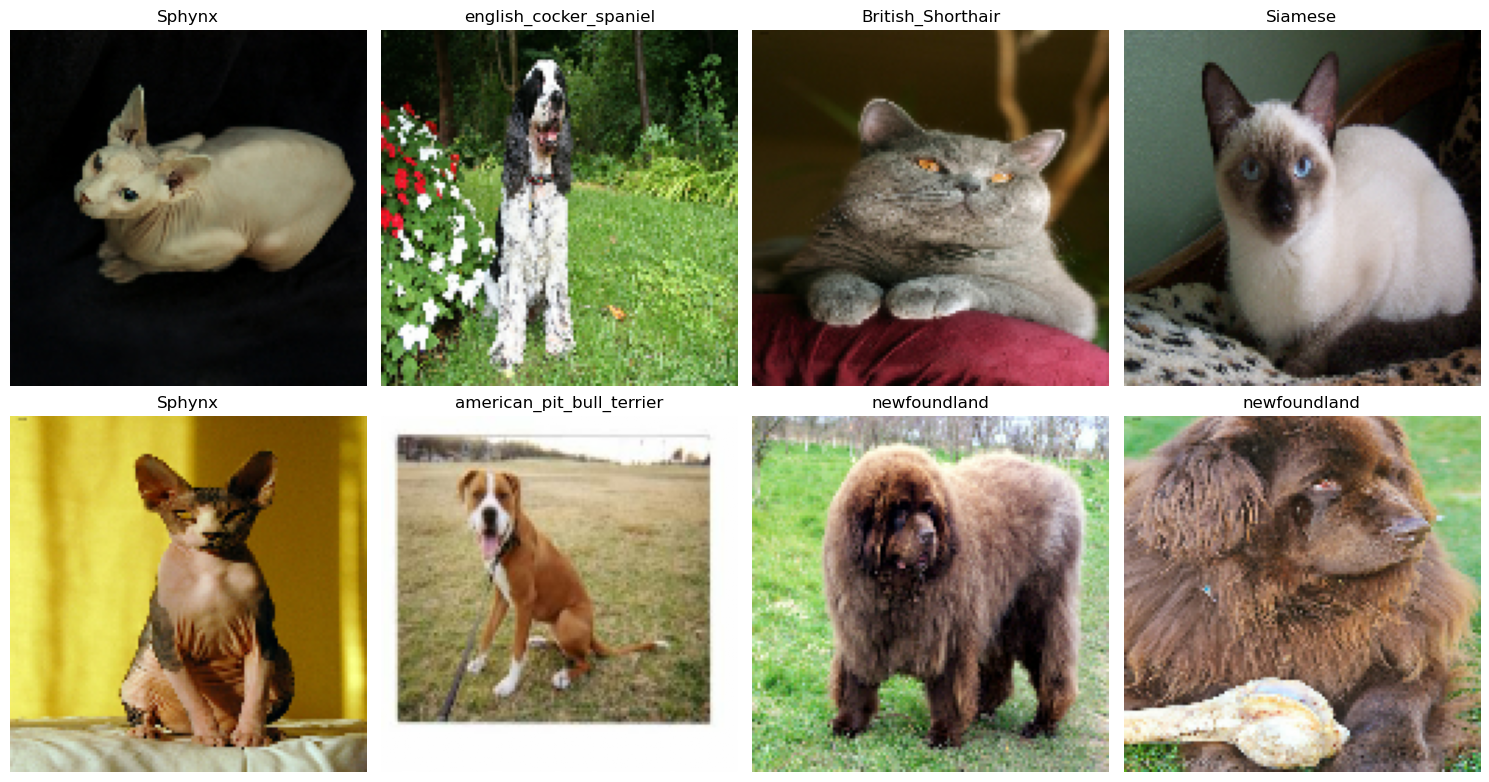

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

@tf.function(input_signature=[
    tf.TensorSpec(shape=[None, None, 3], dtype=tf.uint8),
    tf.TensorSpec(shape=[], dtype=tf.int64)
])
def resize_and_format(image, label):
    # Resize the image to a consistent shape.
    image = tf.image.resize(image, [128, 128])
    
    # Cast the image to float32 and scale pixel values to the [0, 1] range.
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

# Apply the preprocessing function and then batch
train_ds = train_ds.map(resize_and_format)
train_ds = train_ds.batch(8)

for images, labels in train_ds.take(1):
    fig, axs = plt.subplots(2, 4, figsize=(15, 8))
    axs = axs.flatten()

    for i in range(8):
        image = images[i].numpy()
        label = labels[i].numpy()

        axs[i].imshow(image)
        class_name = info.features['label'].int2str(label)

        axs[i].set_title(class_name)
        axs[i].axis('off')

plt.tight_layout()
plt.show()

In this part the model will be train with Xception-like architecture but using convolutional layers to compare with the Separable convolutions

In [4]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [8]:
inputs = keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same', use_bias=False) (residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(37, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
40%37

3

In [10]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_ds, test_ds = dataset['train'], dataset['test']

train_size = tf.data.experimental.cardinality(train_ds).numpy()
train_split = int(train_size*0.8)
val_split = train_size - train_split

train_ds = train_ds.shuffle(buffer_size=train_size)

x_train_ds = train_ds.take(train_split)
x_val_ds = train_ds.skip(train_split)

def preprocess_data(image, label):
    image = tf.image.resize(image, [224,224])
    label = tf.cast(label, tf.int32)%37
    return image, label

x_train_ds = x_train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
x_val_ds = x_val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 32
x_train_ds = x_train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
x_val_ds = x_val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='exception_arch_conv.keras',
        save_best_only = True,
        monitor = 'val_loss'
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True)
    ]

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_history = model.fit(x_train_ds,
                          epochs=30,
                          validation_data = x_val_ds,
                          callbacks = callbacks)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.0367 - loss: 4.1010 - val_accuracy: 0.0245 - val_loss: 3.6654
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.0418 - loss: 3.7209 - val_accuracy: 0.0394 - val_loss: 3.6553
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.0560 - loss: 3.6166 - val_accuracy: 0.0245 - val_loss: 3.7759
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.0700 - loss: 3.5523 - val_accuracy: 0.0408 - val_loss: 3.5473
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.0730 - loss: 3.5208 - val_accuracy: 0.0666 - val_loss: 3.5641
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.0805 - loss: 3.4534 - val_accuracy: 0.0856 - val_loss: 3.4517
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.0842 - loss: 3.4422 - val_accuracy: 0.0910 - val_loss: 3.3889
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.0893 - loss: 3.4021 - val_accuracy: 0.0720 - v

In [11]:
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(val_accuracy) + 1)

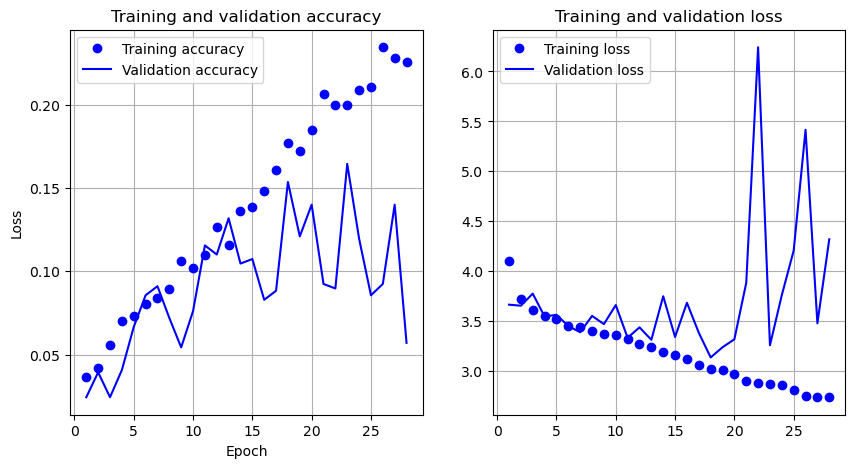

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(epochs, accuracy, 'bo', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)
plt.show()

In [13]:
inputs = keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(x)
x= layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128]:
    residual = x
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SeparableConv2D(size, 3, padding='same', use_bias=False)(x)
    
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = layers.Conv2D(
        size, 1, strides=2, padding='same', use_bias=False) (residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(37, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='exception_arch.keras',
        save_best_only = True,
        monitor = 'val_loss'
    )]

model2.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_history2 = model2.fit(x_train_ds,
                          epochs=30,
                          validation_data = x_val_ds,
                          callbacks = callbacks)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.0350 - loss: 3.6140 - val_accuracy: 0.0312 - val_loss: 3.6054
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - accuracy: 0.0581 - loss: 3.5518 - val_accuracy: 0.0272 - val_loss: 3.6295
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.0642 - loss: 3.5023 - val_accuracy: 0.0353 - val_loss: 3.6428
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0768 - loss: 3.4668 - val_accuracy: 0.0312 - val_loss: 3.6659
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.0812 - loss: 3.4290 - val_accuracy: 0.0462 - val_loss: 3.6933
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0880 - loss: 3.3896 - val_accuracy: 0.0693 - val_loss: 3.4388
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.0914 - loss: 3.3906 - val_accuracy: 0.0611 - val_loss: 3.5443
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.1046 - loss: 3.3490 - val_accuracy: 0.0476 - v

#### <font color=#A0A0A0> **🔘 Selection of hyperparameters**</font>

#### <font color=#A0A0A0> **🧪 Testing the network with another data set**</font>

#### <font color=#A0A0A0> **🧐 Performance Summary**</font>

#### <font color=#A0A0A0> **🧐✅ Conclusions**</font>